In [1]:
import numpy as np
import pandas as pd
import re
import dill as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from eval import *

sns.set_style('whitegrid')
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 300

In [2]:
from keras import Input, layers
from keras.activations import sigmoid
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K

Using TensorFlow backend.


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Load pre-processed data

In [5]:
feats = pickle.load(open('data/feats.pkl', 'rb'))

# Categorical features
cat_ix_trn, cat_ix_dev, cat_ix_test, cat_ix_trn_dev = feats['cat_ix_trn'], feats['cat_ix_dev'], feats['cat_ix_test'], feats['cat_ix_trn_dev']

# Numerical features
cont_trn, cont_dev, cont_test, cont_trn_dev = feats['cont_trn'], feats['cont_dev'], feats['cont_test'], feats['cont_trn_dev']

# Labels
y_trn_oh, y_dev_oh, y_test_oh, y_trn_dev_oh = feats['y_trn_oh'], feats['y_dev_oh'], feats['y_test_oh'], feats['y_trn_dev_oh']

# Supporting data
cat_vars, cont_vars = feats['cat_vars'], feats['cont_vars']
cat_mappers = feats['cat_mappers']
max_len_trn, max_len_dev, max_len_test = feats['max_len_trn'], feats['max_len_dev'], feats['max_len_test']

## Build model

In [5]:
K.clear_session()

### Encode categorical features

In [6]:
def encode_cat(input_dim, output_dim, input_len=None, name=None):
    input_tensor = Input(shape=(input_len, ), name=name)
    output_tensor = layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True, input_length=input_len, name='embeded_{}'.format(name))(input_tensor)
    return input_tensor, output_tensor

In [7]:
# Extract input and output dimensions
cat_input_dims = {var: len(cat_mappers[var]['itos']) for var in cat_vars}
cat_output_dims = {var: min(256, len(cat_mappers[var]['itos']) // 2) for var in cat_vars}

In [8]:
# Encode all categorical variables
cat_input_tensors = {}
cat_output_tensors = {}
for var in cat_vars:
    cat_input_tensors[var], cat_output_tensors[var] = encode_cat(cat_input_dims[var], cat_output_dims[var], name=var)

### Encode numerical features

In [9]:
def encode_cont(input_len=None, name=None, padding_value=-1.):
    input_tensor = Input(shape=(input_len, 1), name=name)
    
    # Add a masking layer to mask the padding value
    output_tensor = layers.Masking(mask_value=padding_value, input_shape=(input_len, 1), name='masked_{}'.format(name))(input_tensor)
    return input_tensor, output_tensor

In [10]:
# Encode all continuous variables
cont_input_tensors = {}
cont_output_tensors = {}
for var in cont_vars:
    cont_input_tensors[var], cont_output_tensors[var] = encode_cont(name=var)

### Concatenate encoded features

In [11]:
cat_cont_output_tensors = [cat_output_tensors[var] for var in cat_vars] + [cont_output_tensors[var] for var in cont_vars]
len(cat_cont_output_tensors)

30

In [12]:
concat_tensor = layers.Concatenate(name='concat')(cat_cont_output_tensors)

In [13]:
# Add batch normalization
concat_tensor_norm = layers.BatchNormalization()(concat_tensor)

### Feed into RNN

In [14]:
def add_bidir_rnn_layers(x, rnn_type, rnn_hidden_units, rnn_input_dropout, rnn_layers):
    for i in range(rnn_layers):
        if rnn_type == 'GRU':
            x = layers.Bidirectional(layers.GRU(units=rnn_hidden_units, dropout=rnn_input_dropout, return_sequences=True))(x)
        elif rnn_type == 'LSTM':
            x = layers.Bidirectional(layers.LSTM(units=rnn_hidden_units, dropout=rnn_input_dropout, return_sequences=True))(x)
    return x

In [15]:
rnn_type = 'GRU'
rnn_hidden_units = 256
rnn_input_dropout = .3
rnn_layers = 1

rnn_output = add_bidir_rnn_layers(concat_tensor_norm, rnn_type, rnn_hidden_units, rnn_input_dropout, rnn_layers)

### Add final dense layers

In [16]:
def add_final_dense_layers(x, dense_units, activations, dropouts):
    for i in range(len(dense_units)):
        x = layers.Dropout(dropouts[i])(x)
        x = layers.Dense(units=dense_units[i], activation=activations[i])(x)
    return x

In [17]:
dense_units = [256, y_trn_oh.shape[-1]]
activations = ['relu', 'softmax']
dropouts = [.2, .1]

dense_output = add_final_dense_layers(rnn_output, dense_units, activations, dropouts)

### Put everything together

In [18]:
inputs = [cat_input_tensors[var] for var in cat_vars] + [cont_input_tensors[var] for var in cont_vars]
rnn = Model(inputs=inputs, outputs=dense_output)
rnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
track (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
user (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
countries (InputLayer)          (None, None)         0                                            
__________________________________________________________________________________________________
client (InputLayer)             (None, None)         0                                            
__________________________________________________________________________________________________
session (I

In [19]:
# Compile
lr = .001
optimizer = Adam(lr=lr)

rnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Define custom metrics
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.metrics = []

    def on_epoch_end(self, epoch, logs={}):
        # Extract validation data
        input_len = len(self.model.input)
        x_val = list(self.validation_data[:input_len])
        y_val = self.validation_data[input_len]
        
        # Generate predictions
        y_val_pred_prob = self.model.predict(x_val)
        
        # Reshape to 2D (thus concatenating all observations together)
        y_val_rs = y_val.reshape(-1, 3)
        y_val_pred_prob_rs = y_val_pred_prob.reshape(-1, 3)

        # Remove padded observations
        # (the first vertical axis indicates whether it's a padded observation or not)
        non_pad_ix = np.where(y_val_rs[:, 0] == 0)[0]
        y_val_rs = y_val_rs[non_pad_ix, :]
        y_val_pred_prob_rs = y_val_pred_prob_rs[non_pad_ix, :]

        # Only evaluate on the positive class
        y_val_rs = y_val_rs[:, -1]
        y_val_pred_prob_rs = y_val_pred_prob_rs[:, -1]
        
        # Compute metrics
        metrics = evaluate_metrics(y_val_rs, y_val_pred_prob_rs)
        print(' - val_f1: {} - val_accuracy: {} - val_auroc: {} - val_avg_logloss: {}'.format(round(metrics['F1'], 3), round(metrics['accuracy'], 3), round(metrics['auroc'], 3), round(metrics['avglogloss'], 3)))
        self.metrics.append(metrics)
        
        return

In [21]:
# Add callbacks
callbacks = []

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks.append(reduce_lr)

stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(stopper)

checkpoint = ModelCheckpoint(filepath='models/gru.h5', monitor='val_loss', save_best_only=True, verbose=1)
callbacks.append(checkpoint)

# Due to the amount of time it takes to generate predictions on the dev set,
# custom metrics are not computed.
# metrics = Metrics()
# callbacks.append(metrics)

In [22]:
# Put togther training and validation data
x_trn = [cat_ix_trn[var] for var in cat_vars] + [cont_trn[var] for var in cont_vars]
x_dev = [cat_ix_dev[var] for var in cat_vars] + [cont_dev[var] for var in cont_vars]

## Train model

In [23]:
epochs = 20
bs = 64

In [ ]:
# Train
rnn_hist = rnn.fit(
    x=x_trn,
    y=y_trn_oh,
    batch_size=bs,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_dev, y_dev_oh),
    shuffle=True)

Train on 6447 samples, validate on 6437 samples
Epoch 1/20
6447/6447 [==============================] - 734s 114ms/step - loss: 0.3942 - acc: 0.8565 - val_loss: 0.3777 - val_acc: 0.8504

Epoch 00001: val_loss improved from inf to 0.37769, saving model to models/gru.h5


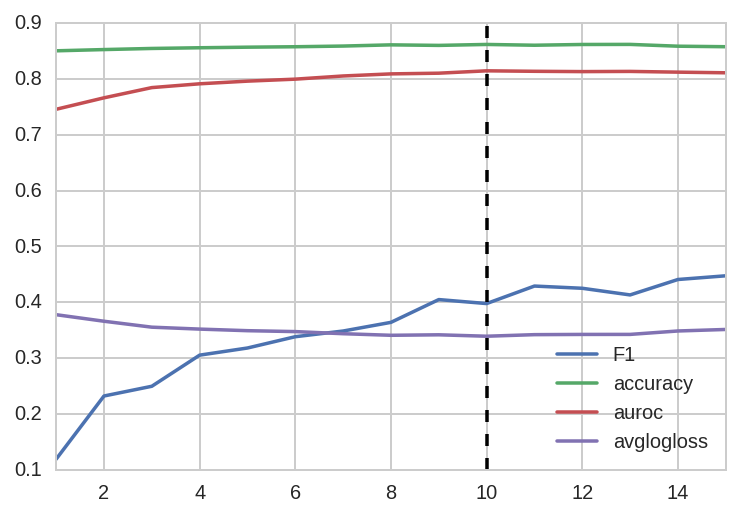

In [25]:
# Plot metrics
metrics_df = pd.DataFrame(metrics.metrics)
metrics_df.index = range(1, len(metrics_df) + 1)

# Find the epoch with the smallest loss
min_loss_ix = metrics_df['avglogloss'].idxmin()

# Plot
ax = metrics_df.plot()
ax.axvline(x=min_loss_ix, color='black', ls='--')

## Re-train using both the traning and dev data

In [30]:
epochs = 10
bs = 64
x_trn_dev = [cat_ix_trn_dev[var] for var in cat_vars] + [cont_trn_dev[var] for var in cont_vars]

In [ ]:
rnn_combined_hist = rnn.fit(
    x=x_trn_dev,
    y=y_trn_dev_oh,
    batch_size=bs,
    epochs=epochs,
    shuffle=True)

Epoch 1/10
 320/6447 [>.............................] - ETA: 10:57 - loss: 0.7161 - acc: 0.7174

In [33]:
rnn.save('models/gru_trn_dev_combined.h5')